<a href="https://colab.research.google.com/github/Pasindu-Madhuwantha/DL_ASSIGNMENT/blob/IT20610098/2.notebooks/DL_Stock_Price_Time_Series_Prediction_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Load Dataset

In [2]:
# Load the dataset from the CSV file (replace 'your_dataset.csv' with your file name)
df = pd.read_csv('/content/drive/MyDrive/DATA.csv')

#Data Preprocessing

[0.63927572 0.63260448 0.63461641 0.63313394 0.64044052 0.63456347
 0.64239958 0.63895806] 0.6396463214606183
[0.63260448 0.63461641 0.63313394 0.64044052 0.63456347 0.64239958
 0.63895806 0.63964632] 0.6290040931970141


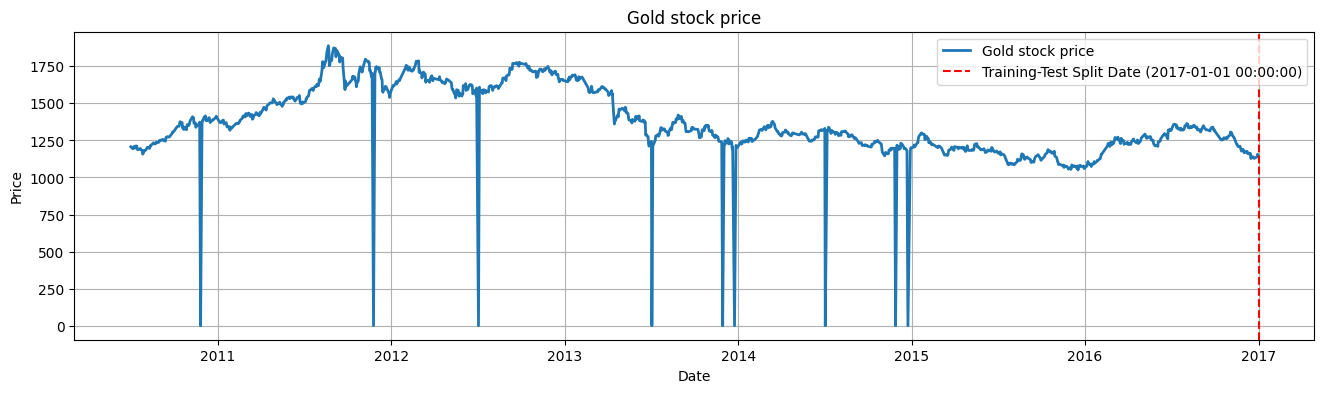

In [3]:
# Rename the columns
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'NASDAQ', 'NYSE', 'S&P 500', 'FTSE100',
              'NIKKI225', 'BSE SENSEX', 'RUSSELL2000', 'HENG SENG', 'SSE', 'Crude Oil', 'Gold', 'VIX',
              'USD index', 'Amazon', 'Google', 'Microsoft']

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Section 1: Data Cleaning - Remove Rows with NaN Values
df.dropna(inplace=True)

# Section 2: Data Preprocessing - Scale the Target Variable (e.g., 'Gold')
sc = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = sc.fit_transform(df[['Gold']])  # Assuming 'Gold' is the target variable

# Set the number of timesteps
timesteps = 8

# Create data sets where each sample has 8 timesteps and 1 output
x_train = []
y_train = []

for i in range(timesteps, len(train_data_scaled)):
    x_train.append(train_data_scaled[i - timesteps:i, 0])
    y_train.append(train_data_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Print the first two samples
print(x_train[0], y_train[0])
print(x_train[1], y_train[1])

# Section 3: Choose Target Variable and Date Range
target = 'Gold'
train_start_date = pd.to_datetime(datetime.date(2010, 7, 1))
train_end_date = pd.to_datetime(datetime.date(2017, 1, 1))
test_start_date = train_end_date

# Section 4: Filter Data Based on Date Range
train_data = df[(df['Date'] >= train_start_date) & (df['Date'] <= train_end_date)]
test_data = df[df['Date'] >= test_start_date]

# Plot Gold Stock Price
plt.figure(figsize=(16, 4))
plt.plot(train_data['Date'], train_data[target], label=f'{target} stock price', linewidth=2)
plt.axvline(x=train_end_date, color='r', linestyle='--', label=f'Training-Test Split Date ({train_end_date})')
plt.legend()
plt.title(f'{target} stock price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [4]:
# Check for NaN values in the entire DataFrame
nan_count = df.isna().sum()

# Print the count of NaN values for each column
print(nan_count)

# Check if there are any NaN values in the entire DataFrame
if nan_count.sum() > 0:
    print("There are NaN values in the DataFrame.")
else:
    print("No NaN values found in the DataFrame.")


Date           0
Open           0
High           0
Low            0
Close          0
Volume         0
NASDAQ         0
NYSE           0
S&P 500        0
FTSE100        0
NIKKI225       0
BSE SENSEX     0
RUSSELL2000    0
HENG SENG      0
SSE            0
Crude Oil      0
Gold           0
VIX            0
USD index      0
Amazon         0
Google         0
Microsoft      0
dtype: int64
No NaN values found in the DataFrame.


#Split Data to train and test

In [5]:


# Convert train_end_date to a datetime object
train_end_date = pd.to_datetime(train_end_date)

# Manually split the data based on date
train_data = df[df['Date'] <= train_end_date]
test_data = df[df['Date'] > train_end_date]


#Data Preprocessing for Time Series Forecasting

In [6]:
# Use MinMaxScaler to scale the training_set
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(train_data[['Gold']])  # Assuming 'Gold' is the target variable

# Set the number of timesteps
timesteps = 8

# Create data sets where each sample has 8 timesteps and 1 output
x_train = []
y_train = []

for i in range(timesteps, len(training_set_scaled)):
    x_train.append(training_set_scaled[i - timesteps:i, 0])
    y_train.append(training_set_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape input data
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

# Shuffle data if necessary (uncomment if needed)
# idx = np.random.permutation(len(x_train))
# x_train = x_train[idx]
# y_train = y_train[idx]

# Print the first two samples
print(x_train[0], y_train[0])
print(x_train[1], y_train[1])


[[0.63927572]
 [0.63260448]
 [0.63461641]
 [0.63313394]
 [0.64044052]
 [0.63456347]
 [0.64239958]
 [0.63895806]] 0.6396463214606183
[[0.63260448]
 [0.63461641]
 [0.63313394]
 [0.64044052]
 [0.63456347]
 [0.64239958]
 [0.63895806]
 [0.63964632]] 0.6290040931970141


In [7]:
#Checking on NaNs

input_shape = x_train.shape[1:]
print(input_shape)


nan_indices = np.isnan(x_train) | np.isnan(y_train)
if np.any(nan_indices):
    print("Found NaN values in the data.")


(8, 1)


#Model Adaptation

In [8]:
# Define the transformer_encoder function
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_blocks, mha_dropout=0, mlp_dropout=0):
    x = inputs

    for _ in range(num_blocks):
        # Multi-Head Self-Attention
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        attn_output = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=mha_dropout
        )(x, x)
        x = layers.Dropout(mha_dropout)(attn_output)
        res = x + inputs

        # Feed Forward Neural Network (FFN)
        x = layers.LayerNormalization(epsilon=1e-6)(res)
        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        x = layers.Dropout(mlp_dropout)(x)
        x = x + res

    return x

# Define the build_model function
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, num_blocks=num_transformer_blocks, mha_dropout=dropout, mlp_dropout=mlp_dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)  # Linear activation for regression
    return keras.Model(inputs, outputs)

# Define the learning rate scheduler function
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs + decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

# Define callbacks and input_shape
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.LearningRateScheduler(lr_scheduler)
]

# Replace 'x_train' and 'y_train' with your actual training data
# input_shape should match the shape of your input data
input_shape = (8, 1)  # Modify this according to your data shape

# Build the model
model = build_model(
    input_shape,
    head_size=46,
    num_heads=60,
    ff_dim=55,
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

# Compile the model
model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"],
)

# Train the model
history = model.fit(
    x_train,  # Replace with your training data
    y_train,  # Replace with your training data
    validation_split=0.2,
    epochs=100,
    batch_size=20,
    callbacks=callbacks,
)

Epoch 1/100
54/54 [==============================] - 102s 155ms/step - loss: 0.5932 - mean_squared_error: 0.5932 - val_loss: 0.3898 - val_mean_squared_error: 0.3898 - lr: 1.0000e-06
Epoch 2/100
54/54 [==============================] - 7s 123ms/step - loss: 0.4105 - mean_squared_error: 0.4105 - val_loss: 0.1174 - val_mean_squared_error: 0.1174 - lr: 3.4300e-05
Epoch 3/100
54/54 [==============================] - 6s 114ms/step - loss: 0.1283 - mean_squared_error: 0.1283 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - lr: 6.7600e-05
Epoch 4/100
54/54 [==============================] - 6s 117ms/step - loss: 0.0568 - mean_squared_error: 0.0568 - val_loss: 5.2514e-04 - val_mean_squared_error: 5.2514e-04 - lr: 1.0090e-04
Epoch 5/100
54/54 [==============================] - 5s 93ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 5.5367e-04 - val_mean_squared_error: 5.5367e-04 - lr: 1.3420e-04
Epoch 6/100
54/54 [==============================] - 5s 94ms/step - loss: 0.0324 - 

#Evaluate model

23/23 [==============================] - 3s 25ms/step
Mean Squared Error (MSE): 24485.77
Mean Absolute Error (MAE): 45.83
R-squared (R2): 0.40


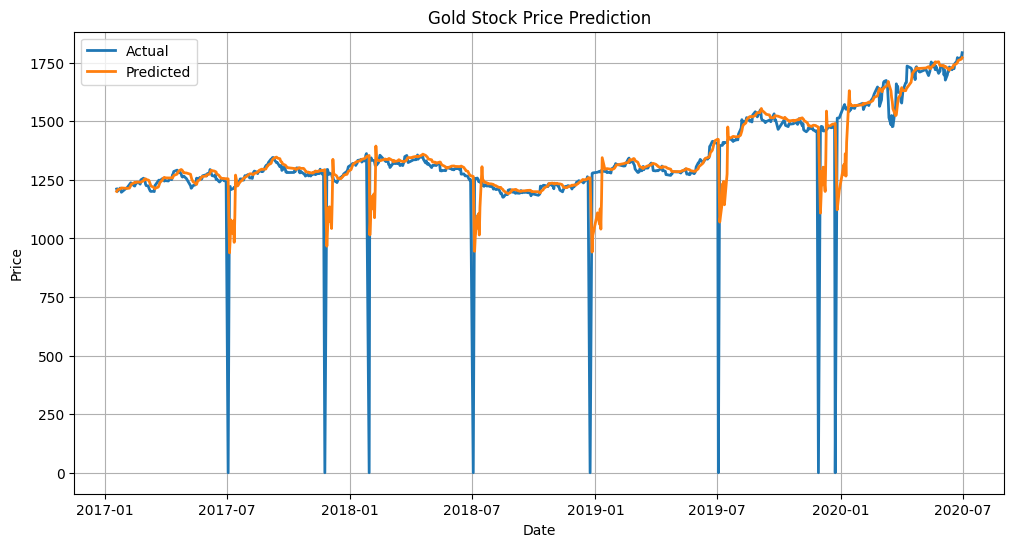

In [9]:
# Evaluate the model on test data
test_data_scaled = sc.transform(test_data[['Gold']])  # Scale test data

# Create sequences for test data
x_test = []
y_test = []

for i in range(timesteps, len(test_data_scaled)):
    x_test.append(test_data_scaled[i - timesteps:i, 0])
    y_test.append(test_data_scaled[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

# Reshape input data
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Predict on test data
y_pred = model.predict(x_test)

# Inverse transform the predictions and actual values to the original scale
y_pred = sc.inverse_transform(y_pred)
y_test = sc.inverse_transform(y_test.reshape(-1, 1))


# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Plot actual vs. predicted values
test_dates = test_data['Date'].iloc[timesteps:]  # Exclude the first timesteps dates
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label='Actual', linewidth=2)
plt.plot(test_dates, y_pred, label='Predicted', linewidth=2)
plt.title('Gold Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


65/65 [==============================] - 1s 20ms/step


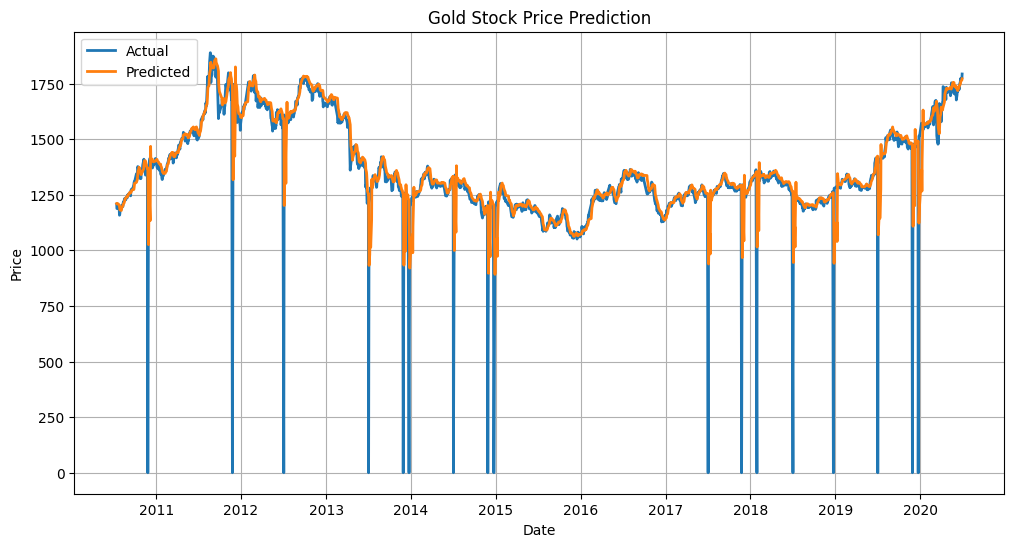

65/65 [==============================] - 1s 18ms/step


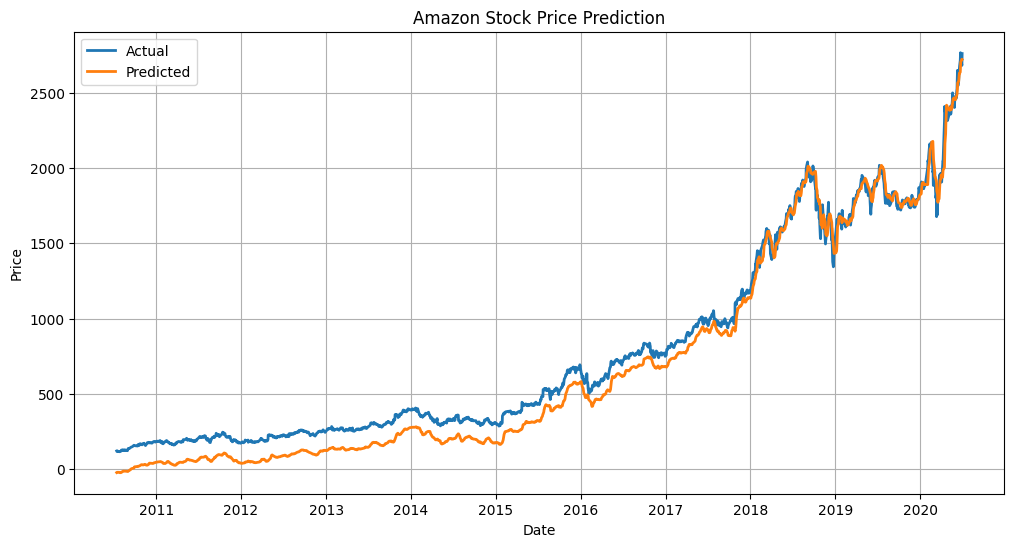

65/65 [==============================] - 1s 18ms/step


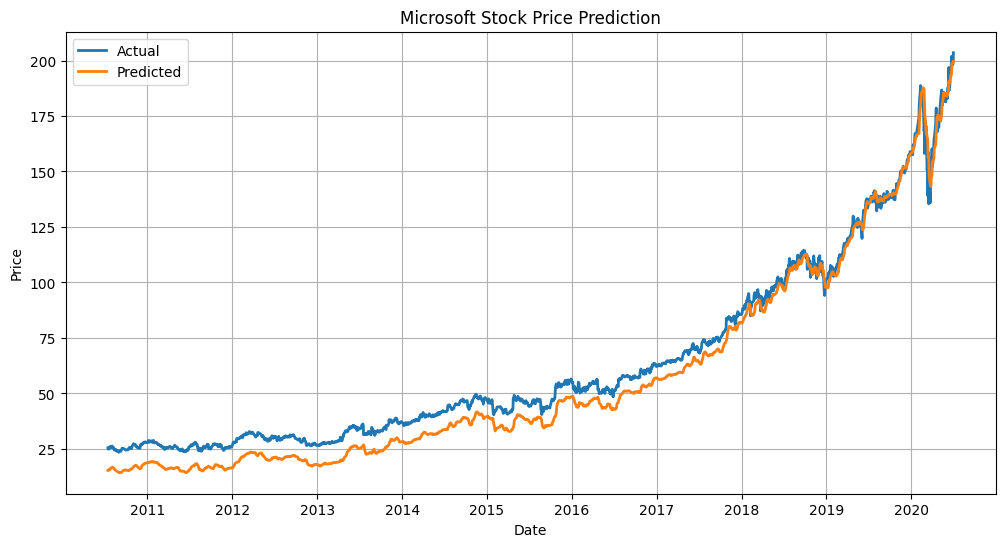

65/65 [==============================] - 1s 19ms/step


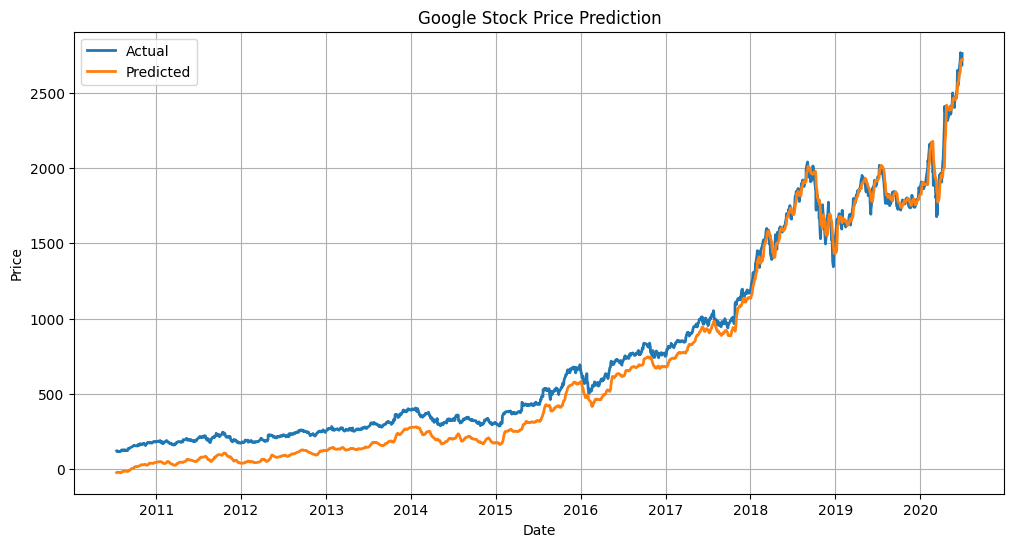

65/65 [==============================] - 1s 21ms/step


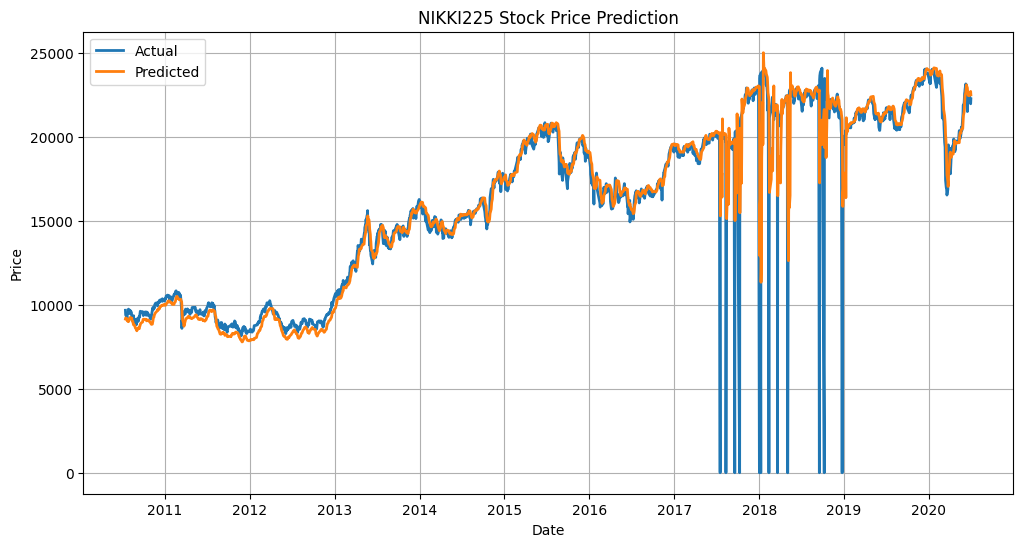

65/65 [==============================] - 1s 19ms/step


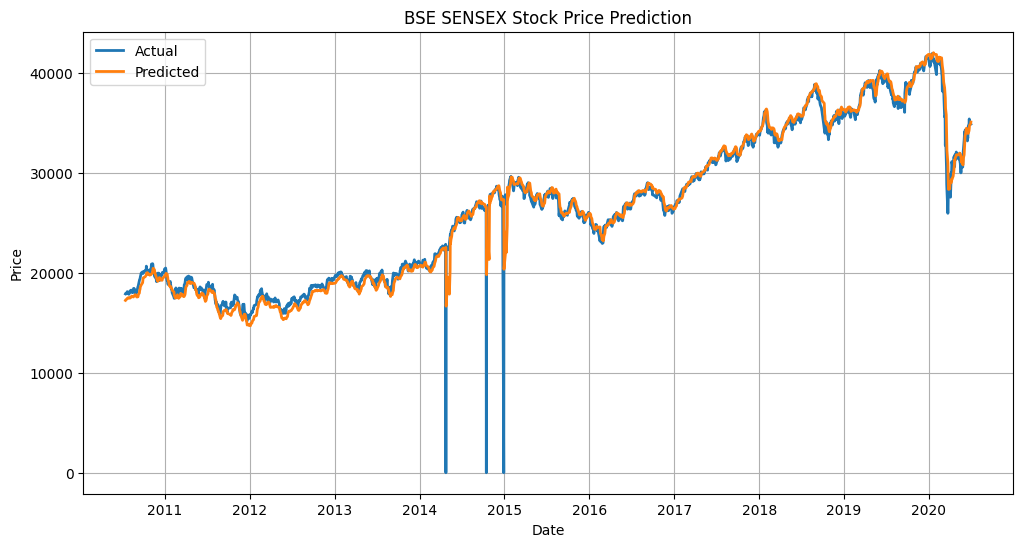

65/65 [==============================] - 1s 19ms/step


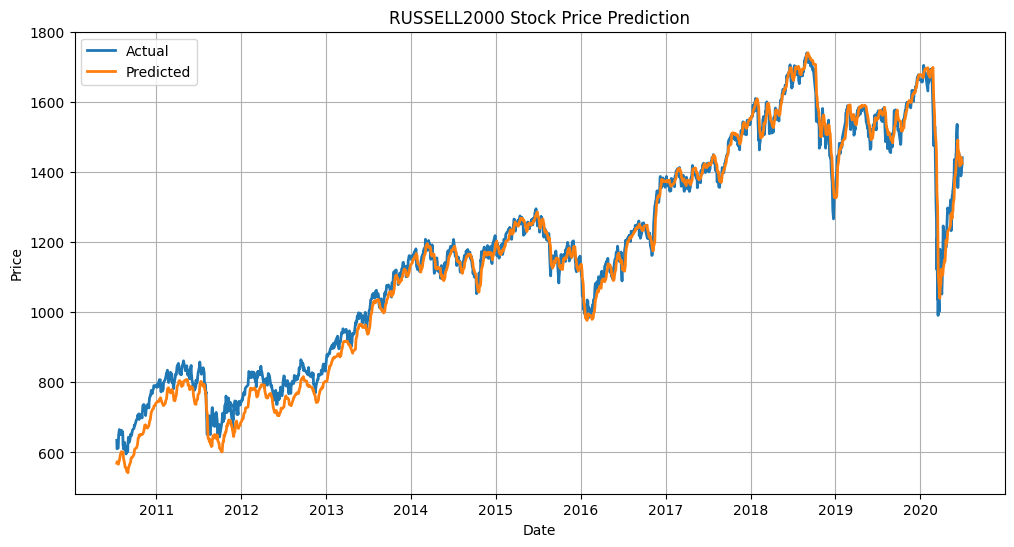

65/65 [==============================] - 1s 19ms/step


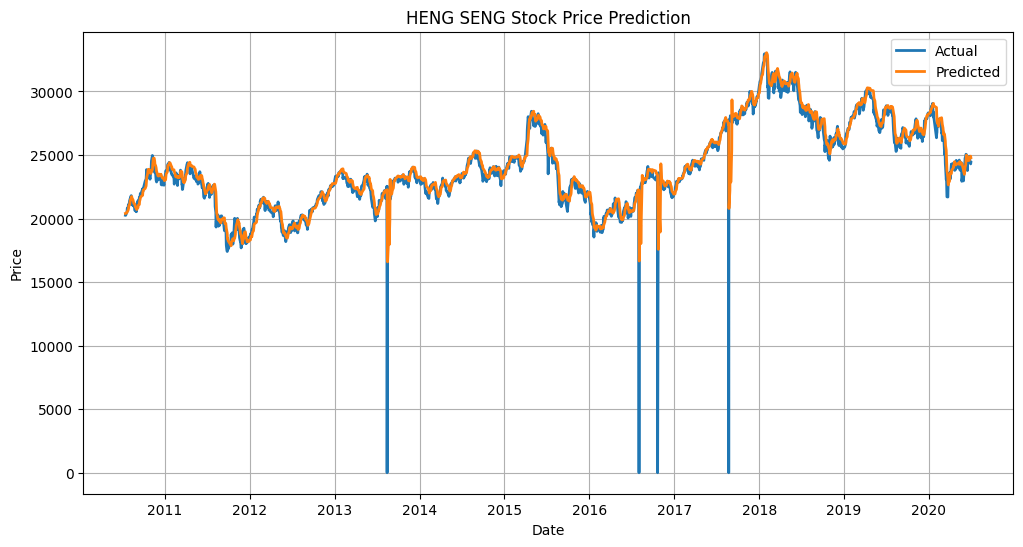

65/65 [==============================] - 1s 19ms/step


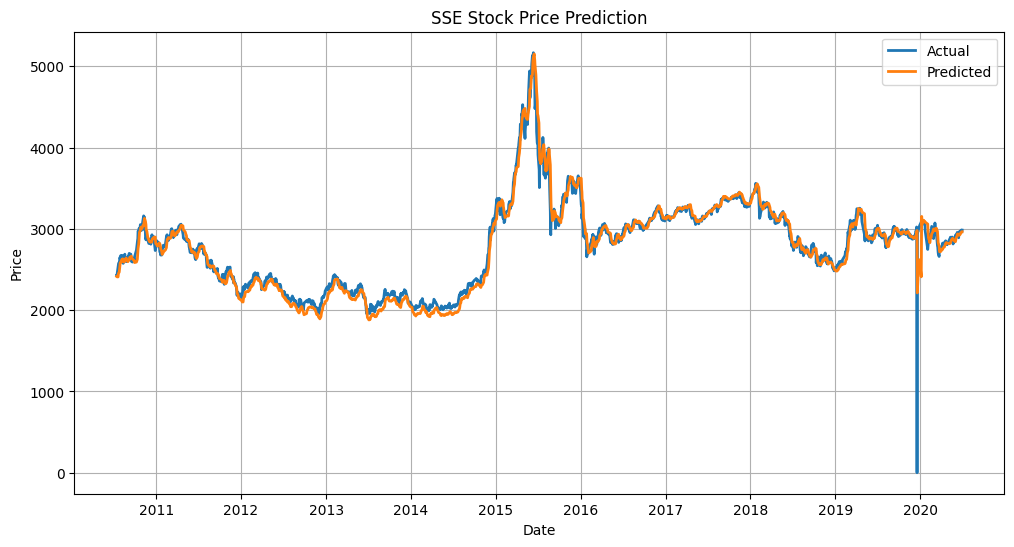

65/65 [==============================] - 1s 20ms/step


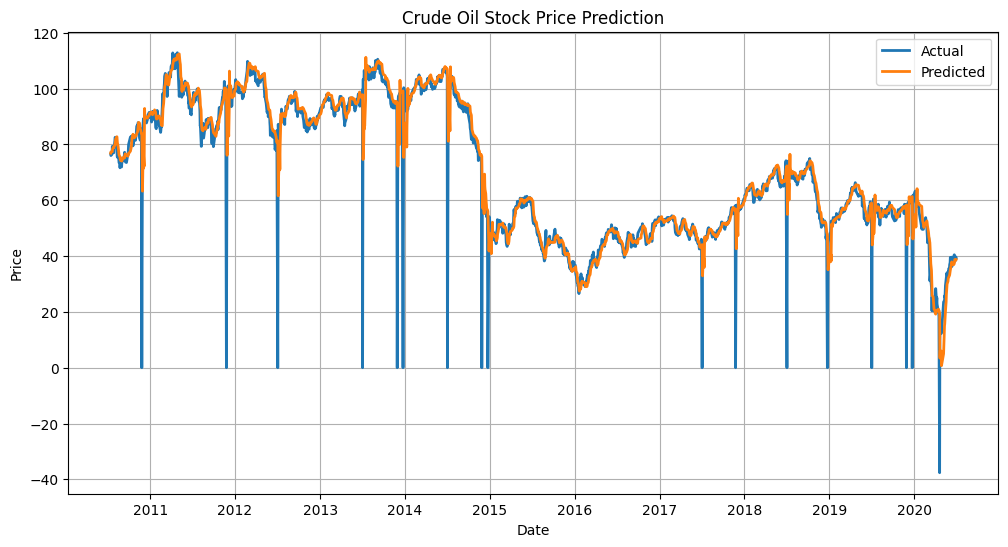

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the dataset from Google Drive
# Replace 'your_google_drive_link' with the actual link to your CSV file
data = pd.read_csv('/content/drive/MyDrive/DATA.csv')

# Data Preprocessing
# Rename columns (ensure they match the columns in your training data)
data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'NASDAQ', 'NYSE', 'S&P 500', 'FTSE100', 'NIKKI225', 'BSE SENSEX', 'RUSSELL2000', 'HENG SENG', 'SSE', 'Crude Oil', 'Gold', 'VIX', 'USD index', 'Amazon', 'Google', 'Microsoft']

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Section 1: Data Cleaning - Remove Rows with NaN Values
data.dropna(inplace=True)

# Define a function to make predictions for a given asset
def predict_asset(asset_name):
    # Create a new MinMaxScaler for the asset data
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Scale the asset data
    asset_data_scaled = scaler.fit_transform(data[[asset_name]])

    # Create sequences for the asset data
    x_asset = []
    y_asset = []

    for i in range(timesteps, len(asset_data_scaled)):
        x_asset.append(asset_data_scaled[i - timesteps:i, 0])
        y_asset.append(asset_data_scaled[i, 0])

    x_asset, y_asset = np.array(x_asset), np.array(y_asset)

    # Reshape input data
    x_asset = x_asset.reshape((x_asset.shape[0], x_asset.shape[1], 1))

    # Predict on the asset data
    asset_predictions = model.predict(x_asset)

    # Inverse transform the predictions to the original scale
    asset_predictions = scaler.inverse_transform(asset_predictions)

    return asset_predictions

# List of asset names you want to predict
asset_names = ['Gold', 'Amazon', 'Microsoft','Google','NIKKI225', 'BSE SENSEX', 'RUSSELL2000', 'HENG SENG', 'SSE', 'Crude Oil']  # Add more assets as needed

# Plot actual vs. predicted values for each asset
for asset_name in asset_names:
    asset_predictions = predict_asset(asset_name)
    dates = data['Date'][timesteps:]

    plt.figure(figsize=(12, 6))
    plt.plot(dates, data[asset_name][timesteps:], label='Actual', linewidth=2)
    plt.plot(dates, asset_predictions, label='Predicted', linewidth=2)
    plt.title(f'{asset_name} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
